In [ ]:
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf
!pip install mujoco
!pip install gymnasium[mujoco]
!mkdir -p ~/.mujoco
!wget https://mujoco.org/download/mujoco210-linux-`x86_64.tar.gz -O mujoco.tar.gz
!tar -xvzf mujoco.tar.gz -C ~/.mujoco
!rm mujoco.tar.gz
!wget https://roboti.us/file/mjkey.txt -O ~/.mujoco/mjkey.txt
!pip install imageio[ffmpeg]
!pip install omegaconf

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [53.5 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,889 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,167 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:13 https://ppa.launchpadcontent.n

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] += ':/root/.mujoco/mujoco210/bin'
os.environ['MUJOCO_GL'] = 'egl'

import copy
import random
import collections

import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

from omegaconf import OmegaConf

from IPython.display import Video, display

In [ ]:
def record_video(env, agent, video_folder):
    state, _ = env.reset()
    terminated, truncated = False, False
    total_reward = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()  # 평가 모드로 전환
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()  # 학습 모드로 전환

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

    env.close()
    return total_reward

In [ ]:
env = gym.make('HalfCheetah-v4', render_mode='rgb_array')
AC_config = OmegaConf.create({
    # RL parameter
    'gamma': 0.99,

    'buffer_limit': int(1e6),  # increased buffer size for more stability
    'batch_size': 256,  # larger batch size for more stable updates

    # neural network parameters
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'state_dim': env.observation_space.shape[0],
    'action_dim': int(env.action_space.shape[0]),  # cannot use .n because actions are continuous!

    # learning parameters
    'lr_actor': 0.0004,  # lower learning rate for more stable updates
    'lr_critic': 0.0004,  # lower learning rate for more stable updates
    'tau': 0.005,  # soft update parameter

    # noise parameters
    'exploration_theta': 0.1,
    'exploration_sigma': 0.05,
    'policy_theta': 0.1,
    'policy_sigma': 0.05,
    'dt': 0.01,

    # TD3 specific parameters
    'policy_delay': 2,  # frequency of delayed policy updates
})

In [ ]:
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.buffer = collections.deque(maxlen=self.config.buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, next_s_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, next_s, done = transition
            s_lst.append(s.tolist())
            a_lst.append(a.tolist())
            r_lst.append([r])
            next_s_lst.append(next_s.tolist())
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(a_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(r_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(next_s_lst, dtype=torch.float32).to(self.config.device),
            torch.tensor(done_mask_lst, dtype=torch.float32).to(self.config.device)
        )
    def size(self):
        return len(self.buffer)

In [ ]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu, theta, sigma, dt):
        self.theta = theta
        self.sigma = sigma
        self.dt = dt
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

In [ ]:
def soft_update(net, net_target, tau):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 400)
        self.layer_2 = nn.Linear(400, 300)
        self.layer_3 = nn.Linear(300, 1)

        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 400)
        self.layer_5 = nn.Linear(400, 300)
        self.layer_6 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)

        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)

        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.memory = ReplayBuffer(self.config)
        self.exploration_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.exploration_theta, sigma=self.config.exploration_sigma, dt=self.config.dt)
        self.policy_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(self.config.action_dim), theta=self.config.policy_theta, sigma=self.config.policy_sigma, dt=self.config.dt)
        self.max_action = env.action_space.high[0]

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(self.config.state_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, self.config.action_dim),
            nn.Tanh()
        ).to(self.config.device)

        # Single Critic network with two outputs
        self.critic = Critic(self.config.state_dim, self.config.action_dim).to(self.config.device)

        # Target networks
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.config.lr_actor)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.config.lr_critic)

        self.total_it = 0

    def update(self):
        if self.memory.size() < self.config.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.config.batch_size)

        with torch.no_grad():
            noise = torch.tensor(self.policy_noise(), device=self.config.device, dtype=torch.float32)
            noise = torch.clamp(noise, -0.5, 0.5)
            next_actions = self.actor_target(next_states) + noise
            next_actions = torch.clamp(next_actions, -self.max_action, self.max_action)
            target_q1, target_q2 = self.critic_target(next_states, next_actions)
            target_q = rewards + dones * self.config.gamma * torch.min(target_q1, target_q2)

        current_q1, current_q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

        if self.total_it % self.config.policy_delay == 0:
            actor_loss = -self.critic.Q1(states, self.actor(states)).mean()
            self.actor_opt.zero_grad()
            actor_loss.backward()
            self.actor_opt.step()

            soft_update(self.actor, self.actor_target, self.config.tau)
            soft_update(self.critic, self.critic_target, self.config.tau)
        self.total_it += 1

In [17]:
env = gym.make('HalfCheetah-v4', render_mode='rgb_array')
num_epis = 5000
total_run = 0
epi_rews = []
agent = ActorCritic(AC_config)

eval_interval = 10  # 평가 간격
eval_rews = []

for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0

    while not (terminated or truncated):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.config.device)
        with torch.no_grad():
            agent.actor.eval()
            action = agent.actor(state_tensor).cpu().detach().numpy().squeeze(0)
            agent.actor.train()
        noise = agent.exploration_noise()
        noise = np.clip(noise, -0.5, 0.5)
        action += noise
        action = np.clip(action, -agent.max_action, agent.max_action)
        next_state, reward, terminated, truncated, _ = env.step(action)

        agent.memory.put((state, action, reward, next_state, terminated or truncated))

        state = next_state
        epi_rew += reward
        total_run += 1

        if total_run > 25000:
            agent.update()

    epi_rews.append(epi_rew)

    if (n_epi + 1) % eval_interval == 0:
        avg_rew = np.mean(epi_rews[-eval_interval:])
        print(f"Episode {n_epi + 1}: Average Reward: {avg_rew}", f"Total Steps {total_run}, Total Updates {agent.total_it}")
        eval_rews.append(avg_rew)

    if total_run > int(1e6):
      print(f"Total Step {total_run} Exceeded {int(1e6)}")
      break

env.close()

  0%|          | 10/5000 [00:06<58:24,  1.42it/s]

Episode 10: Average Reward: -8.198769667543699 Total Steps 10000, Total Updates 0


  0%|          | 20/5000 [00:13<55:06,  1.51it/s]

Episode 20: Average Reward: -9.728844654659923 Total Steps 20000, Total Updates 0


  1%|          | 30/5000 [00:54<8:46:02,  6.35s/it]

Episode 30: Average Reward: -198.50025266767472 Total Steps 30000, Total Updates 5000


  1%|          | 40/5000 [02:10<10:29:55,  7.62s/it]

Episode 40: Average Reward: -197.99950021680456 Total Steps 40000, Total Updates 15000


  1%|          | 50/5000 [03:28<10:41:17,  7.77s/it]

Episode 50: Average Reward: 1079.620493776833 Total Steps 50000, Total Updates 25000


  1%|          | 60/5000 [04:46<10:44:16,  7.83s/it]

Episode 60: Average Reward: 1692.613187984886 Total Steps 60000, Total Updates 35000


  1%|▏         | 70/5000 [06:05<10:53:15,  7.95s/it]

Episode 70: Average Reward: 1521.4320397195165 Total Steps 70000, Total Updates 45000


  2%|▏         | 80/5000 [07:26<11:04:42,  8.11s/it]

Episode 80: Average Reward: 2034.824408930146 Total Steps 80000, Total Updates 55000


  2%|▏         | 90/5000 [08:47<11:11:20,  8.20s/it]

Episode 90: Average Reward: 1888.047294518173 Total Steps 90000, Total Updates 65000


  2%|▏         | 100/5000 [10:11<11:20:18,  8.33s/it]

Episode 100: Average Reward: 2080.7320519531554 Total Steps 100000, Total Updates 75000


  2%|▏         | 110/5000 [11:35<11:32:12,  8.49s/it]

Episode 110: Average Reward: 1967.7296053518007 Total Steps 110000, Total Updates 85000


  2%|▏         | 120/5000 [13:02<11:53:35,  8.77s/it]

Episode 120: Average Reward: 2203.4006067221585 Total Steps 120000, Total Updates 95000


  3%|▎         | 130/5000 [14:30<12:00:52,  8.88s/it]

Episode 130: Average Reward: 2452.570802228222 Total Steps 130000, Total Updates 105000


  3%|▎         | 140/5000 [16:00<12:15:16,  9.08s/it]

Episode 140: Average Reward: 2653.488096913693 Total Steps 140000, Total Updates 115000


  3%|▎         | 150/5000 [17:33<12:29:36,  9.27s/it]

Episode 150: Average Reward: 2913.8200035354075 Total Steps 150000, Total Updates 125000


  3%|▎         | 160/5000 [19:07<12:42:29,  9.45s/it]

Episode 160: Average Reward: 3175.33518779289 Total Steps 160000, Total Updates 135000


  3%|▎         | 170/5000 [20:44<12:59:24,  9.68s/it]

Episode 170: Average Reward: 3290.9784085286374 Total Steps 170000, Total Updates 145000


  4%|▎         | 180/5000 [22:23<13:20:50,  9.97s/it]

Episode 180: Average Reward: 3426.9369885710657 Total Steps 180000, Total Updates 155000


  4%|▍         | 190/5000 [24:04<13:34:37, 10.16s/it]

Episode 190: Average Reward: 3467.898211783123 Total Steps 190000, Total Updates 165000


  4%|▍         | 200/5000 [25:48<13:53:42, 10.42s/it]

Episode 200: Average Reward: 3543.3949718864665 Total Steps 200000, Total Updates 175000


  4%|▍         | 210/5000 [27:33<14:09:27, 10.64s/it]

Episode 210: Average Reward: 3590.4725137653795 Total Steps 210000, Total Updates 185000


  4%|▍         | 220/5000 [29:22<14:31:36, 10.94s/it]

Episode 220: Average Reward: 3803.0231087824977 Total Steps 220000, Total Updates 195000


  5%|▍         | 230/5000 [31:12<14:39:58, 11.07s/it]

Episode 230: Average Reward: 4115.609753982917 Total Steps 230000, Total Updates 205000


  5%|▍         | 240/5000 [33:04<14:54:14, 11.27s/it]

Episode 240: Average Reward: 3911.7592025272534 Total Steps 240000, Total Updates 215000


  5%|▌         | 250/5000 [34:59<15:12:26, 11.53s/it]

Episode 250: Average Reward: 4269.414432574943 Total Steps 250000, Total Updates 225000


  5%|▌         | 260/5000 [36:56<15:28:03, 11.75s/it]

Episode 260: Average Reward: 4404.264883202293 Total Steps 260000, Total Updates 235000


  5%|▌         | 270/5000 [38:56<15:47:23, 12.02s/it]

Episode 270: Average Reward: 4397.92909268825 Total Steps 270000, Total Updates 245000


  6%|▌         | 280/5000 [40:57<15:59:30, 12.20s/it]

Episode 280: Average Reward: 4465.872475848344 Total Steps 280000, Total Updates 255000


  6%|▌         | 290/5000 [43:02<16:20:29, 12.49s/it]

Episode 290: Average Reward: 4455.799768704404 Total Steps 290000, Total Updates 265000


  6%|▌         | 300/5000 [45:08<16:31:44, 12.66s/it]

Episode 300: Average Reward: 4863.316583097339 Total Steps 300000, Total Updates 275000


  6%|▌         | 310/5000 [47:16<16:45:45, 12.87s/it]

Episode 310: Average Reward: 4758.750267499179 Total Steps 310000, Total Updates 285000


  6%|▋         | 320/5000 [49:27<17:04:49, 13.14s/it]

Episode 320: Average Reward: 4822.3924522748275 Total Steps 320000, Total Updates 295000


  7%|▋         | 330/5000 [51:40<17:20:04, 13.36s/it]

Episode 330: Average Reward: 4953.404875660411 Total Steps 330000, Total Updates 305000


  7%|▋         | 340/5000 [53:56<17:40:17, 13.65s/it]

Episode 340: Average Reward: 5068.256185353511 Total Steps 340000, Total Updates 315000


  7%|▋         | 350/5000 [56:14<17:49:05, 13.79s/it]

Episode 350: Average Reward: 5137.649470820503 Total Steps 350000, Total Updates 325000


  7%|▋         | 360/5000 [58:35<18:08:19, 14.07s/it]

Episode 360: Average Reward: 5249.343584526522 Total Steps 360000, Total Updates 335000


  7%|▋         | 370/5000 [1:00:58<18:25:14, 14.32s/it]

Episode 370: Average Reward: 5353.142431263443 Total Steps 370000, Total Updates 345000


  8%|▊         | 380/5000 [1:03:22<18:38:33, 14.53s/it]

Episode 380: Average Reward: 5072.256235943231 Total Steps 380000, Total Updates 355000


  8%|▊         | 390/5000 [1:05:50<18:55:27, 14.78s/it]

Episode 390: Average Reward: 5259.661686613095 Total Steps 390000, Total Updates 365000


  8%|▊         | 400/5000 [1:08:20<19:16:11, 15.08s/it]

Episode 400: Average Reward: 5335.547952683068 Total Steps 400000, Total Updates 375000


  8%|▊         | 410/5000 [1:10:52<19:32:16, 15.32s/it]

Episode 410: Average Reward: 5427.125639834487 Total Steps 410000, Total Updates 385000


  8%|▊         | 420/5000 [1:13:27<19:48:16, 15.57s/it]

Episode 420: Average Reward: 5354.333546987025 Total Steps 420000, Total Updates 395000


  9%|▊         | 430/5000 [1:16:05<20:11:50, 15.91s/it]

Episode 430: Average Reward: 5420.975642547839 Total Steps 430000, Total Updates 405000


  9%|▉         | 440/5000 [1:18:45<20:18:56, 16.04s/it]

Episode 440: Average Reward: 5461.096970506722 Total Steps 440000, Total Updates 415000


  9%|▉         | 450/5000 [1:21:28<20:39:11, 16.34s/it]

Episode 450: Average Reward: 5539.625409474812 Total Steps 450000, Total Updates 425000


  9%|▉         | 460/5000 [1:24:13<20:52:54, 16.56s/it]

Episode 460: Average Reward: 5584.295647995184 Total Steps 460000, Total Updates 435000


  9%|▉         | 470/5000 [1:27:00<21:01:44, 16.71s/it]

Episode 470: Average Reward: 5527.861215761009 Total Steps 470000, Total Updates 445000


 10%|▉         | 480/5000 [1:29:51<21:30:35, 17.13s/it]

Episode 480: Average Reward: 5467.45429702763 Total Steps 480000, Total Updates 455000


 10%|▉         | 490/5000 [1:32:43<21:38:02, 17.27s/it]

Episode 490: Average Reward: 5504.972813880179 Total Steps 490000, Total Updates 465000


 10%|█         | 500/5000 [1:35:38<22:00:00, 17.60s/it]

Episode 500: Average Reward: 5753.408130557999 Total Steps 500000, Total Updates 475000


 10%|█         | 510/5000 [1:38:37<22:18:03, 17.88s/it]

Episode 510: Average Reward: 5769.717112535035 Total Steps 510000, Total Updates 485000


 10%|█         | 520/5000 [1:41:39<22:44:53, 18.28s/it]

Episode 520: Average Reward: 5556.3798641574085 Total Steps 520000, Total Updates 495000


 11%|█         | 530/5000 [1:44:43<23:02:27, 18.56s/it]

Episode 530: Average Reward: 5846.976039557061 Total Steps 530000, Total Updates 505000


 11%|█         | 540/5000 [1:47:50<23:08:43, 18.68s/it]

Episode 540: Average Reward: 5900.931299196776 Total Steps 540000, Total Updates 515000


 11%|█         | 550/5000 [1:51:00<23:28:59, 19.00s/it]

Episode 550: Average Reward: 6051.1875144164005 Total Steps 550000, Total Updates 525000


 11%|█         | 560/5000 [1:54:12<23:43:51, 19.24s/it]

Episode 560: Average Reward: 6055.041363061971 Total Steps 560000, Total Updates 535000


 11%|█▏        | 570/5000 [1:57:28<24:08:54, 19.62s/it]

Episode 570: Average Reward: 6205.71389085792 Total Steps 570000, Total Updates 545000


 12%|█▏        | 580/5000 [2:00:48<24:41:15, 20.11s/it]

Episode 580: Average Reward: 5923.508374614297 Total Steps 580000, Total Updates 555000


 12%|█▏        | 590/5000 [2:04:10<24:53:58, 20.33s/it]

Episode 590: Average Reward: 6072.0939455077805 Total Steps 590000, Total Updates 565000


 12%|█▏        | 600/5000 [2:07:36<25:15:33, 20.67s/it]

Episode 600: Average Reward: 6079.254668887765 Total Steps 600000, Total Updates 575000


 12%|█▏        | 610/5000 [2:11:05<25:32:29, 20.95s/it]

Episode 610: Average Reward: 5937.819646268543 Total Steps 610000, Total Updates 585000


 12%|█▏        | 620/5000 [2:14:38<25:58:18, 21.35s/it]

Episode 620: Average Reward: 6240.941547036047 Total Steps 620000, Total Updates 595000


 13%|█▎        | 630/5000 [2:18:12<26:12:56, 21.60s/it]

Episode 630: Average Reward: 6367.488970538851 Total Steps 630000, Total Updates 605000


 13%|█▎        | 640/5000 [2:21:50<26:29:39, 21.88s/it]

Episode 640: Average Reward: 6322.9987880605795 Total Steps 640000, Total Updates 615000


 13%|█▎        | 650/5000 [2:25:32<27:05:52, 22.43s/it]

Episode 650: Average Reward: 6023.458187963122 Total Steps 650000, Total Updates 625000


 13%|█▎        | 660/5000 [2:29:18<27:13:23, 22.58s/it]

Episode 660: Average Reward: 6247.429415648769 Total Steps 660000, Total Updates 635000


 13%|█▎        | 670/5000 [2:33:07<27:30:12, 22.87s/it]

Episode 670: Average Reward: 6276.06503797938 Total Steps 670000, Total Updates 645000


 14%|█▎        | 680/5000 [2:36:57<27:38:35, 23.04s/it]

Episode 680: Average Reward: 6255.318479757842 Total Steps 680000, Total Updates 655000


 14%|█▍        | 690/5000 [2:40:54<28:21:43, 23.69s/it]

Episode 690: Average Reward: 5954.755094976155 Total Steps 690000, Total Updates 665000


 14%|█▍        | 700/5000 [2:44:53<28:45:30, 24.08s/it]

Episode 700: Average Reward: 6245.792355857016 Total Steps 700000, Total Updates 675000


 14%|█▍        | 710/5000 [2:48:56<28:57:15, 24.30s/it]

Episode 710: Average Reward: 6161.1190906837555 Total Steps 710000, Total Updates 685000


 14%|█▍        | 720/5000 [2:53:04<29:40:32, 24.96s/it]

Episode 720: Average Reward: 6299.521419715516 Total Steps 720000, Total Updates 695000


 15%|█▍        | 730/5000 [2:57:16<30:02:07, 25.32s/it]

Episode 730: Average Reward: 6120.92149416344 Total Steps 730000, Total Updates 705000


 15%|█▍        | 740/5000 [3:01:33<30:17:57, 25.60s/it]

Episode 740: Average Reward: 6431.74104826079 Total Steps 740000, Total Updates 715000


 15%|█▌        | 750/5000 [3:05:52<30:35:41, 25.92s/it]

Episode 750: Average Reward: 6414.242701443552 Total Steps 750000, Total Updates 725000


 15%|█▌        | 760/5000 [3:10:15<31:07:02, 26.42s/it]

Episode 760: Average Reward: 6399.287717164919 Total Steps 760000, Total Updates 735000


 15%|█▌        | 770/5000 [3:14:44<31:39:08, 26.94s/it]

Episode 770: Average Reward: 6474.837886986832 Total Steps 770000, Total Updates 745000


 16%|█▌        | 780/5000 [3:19:14<31:50:18, 27.16s/it]

Episode 780: Average Reward: 6231.168590785967 Total Steps 780000, Total Updates 755000


 16%|█▌        | 790/5000 [3:23:50<32:28:18, 27.77s/it]

Episode 790: Average Reward: 6304.272723089396 Total Steps 790000, Total Updates 765000


 16%|█▌        | 800/5000 [3:28:29<32:38:25, 27.98s/it]

Episode 800: Average Reward: 6389.760036254489 Total Steps 800000, Total Updates 775000


 16%|█▌        | 810/5000 [3:33:13<33:13:55, 28.55s/it]

Episode 810: Average Reward: 6216.619947074345 Total Steps 810000, Total Updates 785000


 16%|█▋        | 820/5000 [3:38:01<33:38:47, 28.98s/it]

Episode 820: Average Reward: 6466.623783185607 Total Steps 820000, Total Updates 795000


 17%|█▋        | 830/5000 [3:42:53<33:52:29, 29.24s/it]

Episode 830: Average Reward: 6440.169161557702 Total Steps 830000, Total Updates 805000


 17%|█▋        | 840/5000 [3:47:48<34:00:22, 29.43s/it]

Episode 840: Average Reward: 6420.1924177100855 Total Steps 840000, Total Updates 815000


 17%|█▋        | 850/5000 [3:52:48<34:44:44, 30.14s/it]

Episode 850: Average Reward: 6370.712173372025 Total Steps 850000, Total Updates 825000


 17%|█▋        | 860/5000 [3:57:51<35:03:08, 30.48s/it]

Episode 860: Average Reward: 6699.904635108527 Total Steps 860000, Total Updates 835000


 17%|█▋        | 870/5000 [4:03:00<35:32:33, 30.98s/it]

Episode 870: Average Reward: 6337.193849632775 Total Steps 870000, Total Updates 845000


 18%|█▊        | 880/5000 [4:08:14<36:03:38, 31.51s/it]

Episode 880: Average Reward: 6675.793592403794 Total Steps 880000, Total Updates 855000


 18%|█▊        | 890/5000 [4:13:31<36:17:03, 31.78s/it]

Episode 890: Average Reward: 6608.715640650151 Total Steps 890000, Total Updates 865000


 18%|█▊        | 900/5000 [4:18:53<36:49:22, 32.33s/it]

Episode 900: Average Reward: 6743.346524074079 Total Steps 900000, Total Updates 875000


 18%|█▊        | 910/5000 [4:24:21<37:17:11, 32.82s/it]

Episode 910: Average Reward: 6772.573258633005 Total Steps 910000, Total Updates 885000


 18%|█▊        | 920/5000 [4:29:53<37:45:18, 33.31s/it]

Episode 920: Average Reward: 6702.811680851203 Total Steps 920000, Total Updates 895000


 19%|█▊        | 930/5000 [4:35:30<38:11:28, 33.78s/it]

Episode 930: Average Reward: 6694.875063486567 Total Steps 930000, Total Updates 905000


 19%|█▉        | 940/5000 [4:41:09<38:19:26, 33.98s/it]

Episode 940: Average Reward: 6583.509665860035 Total Steps 940000, Total Updates 915000


 19%|█▉        | 950/5000 [4:46:55<39:03:05, 34.71s/it]

Episode 950: Average Reward: 6845.614983944984 Total Steps 950000, Total Updates 925000


 19%|█▉        | 960/5000 [4:52:45<39:11:10, 34.92s/it]

Episode 960: Average Reward: 6891.762133252252 Total Steps 960000, Total Updates 935000


 19%|█▉        | 970/5000 [4:58:38<39:45:01, 35.51s/it]

Episode 970: Average Reward: 6693.404852207108 Total Steps 970000, Total Updates 945000


 20%|█▉        | 980/5000 [5:04:37<40:04:14, 35.88s/it]

Episode 980: Average Reward: 6970.633788665221 Total Steps 980000, Total Updates 955000


 20%|█▉        | 990/5000 [5:10:39<40:36:32, 36.46s/it]

Episode 990: Average Reward: 6827.294502632234 Total Steps 990000, Total Updates 965000


 20%|██        | 1000/5000 [5:16:44<40:25:39, 36.38s/it]

Episode 1000: Average Reward: 6946.38790580933 Total Steps 1000000, Total Updates 975000


 20%|██        | 1000/5000 [5:17:20<21:09:23, 19.04s/it]

Total Step 1001000 Exceeded 1000000


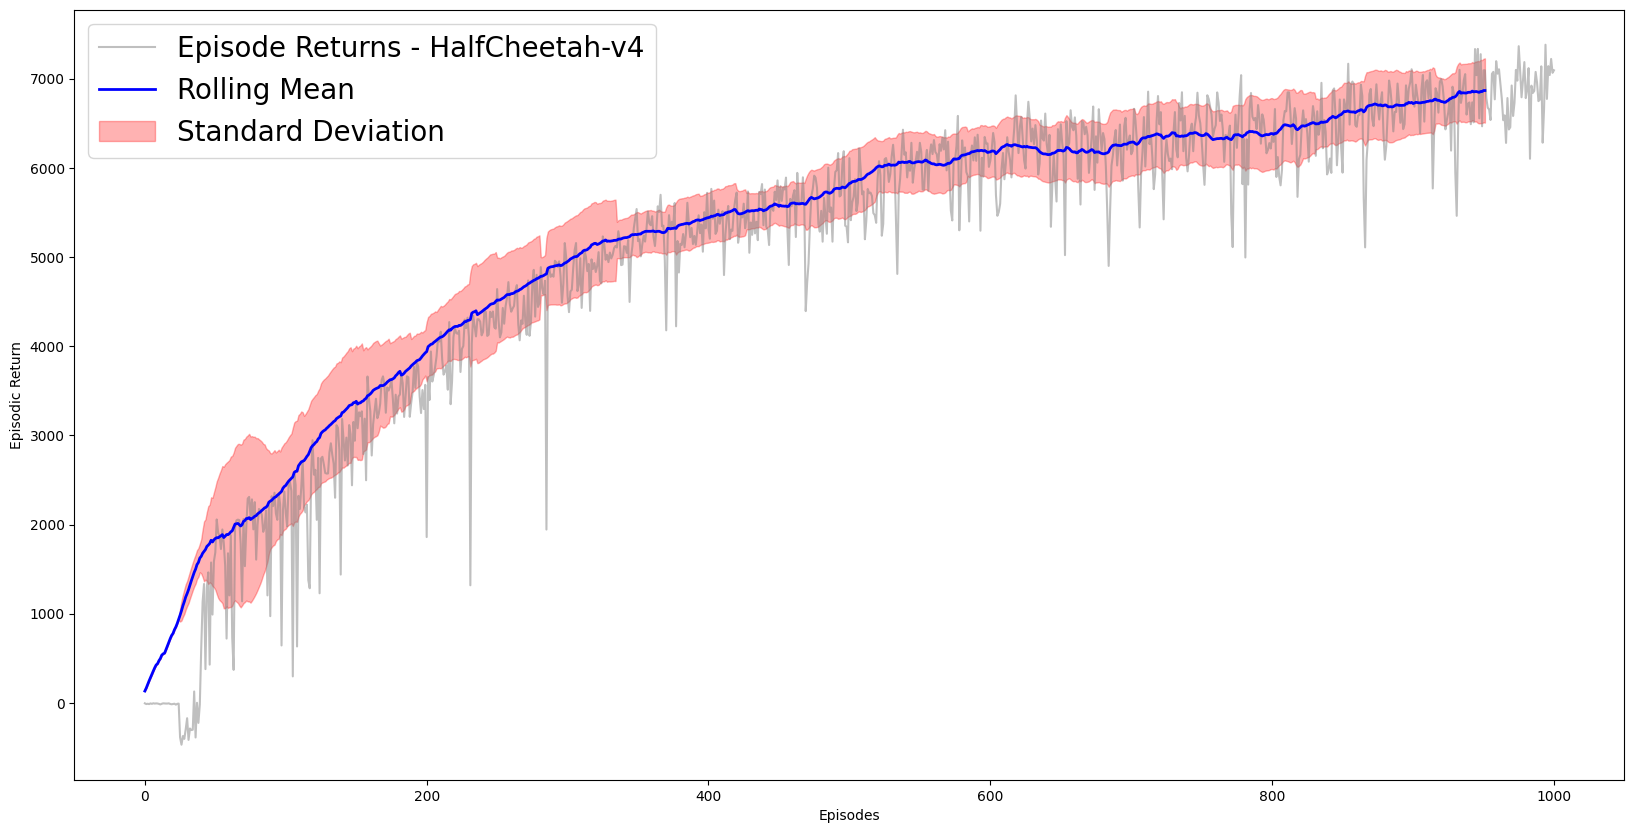

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the rolling mean and standard deviation
window = 50  # Window size for moving average
rolling_mean = np.convolve(epi_rews, np.ones(window)/window, mode='valid')

# Calculate the standard deviation with the same window
rolling_std = np.array([np.std(epi_rews[max(0, i - window + 1):i + 1]) for i in range(len(epi_rews))])
rolling_std = rolling_std[:len(rolling_mean)]  # Match lengths of rolling_mean and rolling_std

# Define the steps variable
steps = np.arange(len(epi_rews))

# Plot the results
plt.figure(figsize=(20, 10))

# Plot the entire episodic returns with a faded color
plt.plot(steps, epi_rews, label='Episode Returns - HalfCheetah-v4', color='grey', alpha=0.5)

# Plot the rolling mean with a thicker line
plt.plot(steps[:len(rolling_mean)], rolling_mean, color='blue', linewidth=2, label='Rolling Mean')

# Plot the standard deviation as a filled area
plt.fill_between(steps[:len(rolling_mean)], rolling_mean - rolling_std, rolling_mean + rolling_std, color='red', alpha=0.3, label='Standard Deviation')

plt.xlabel('Episodes')
plt.ylabel('Episodic Return')
plt.legend(fontsize=20)
plt.show()
plt.close()

In [19]:
  # 비디오 폴더 생성
video_folder = 'videos'
os.makedirs(video_folder, exist_ok=True)

# 비디오 녹화 및 저장
env = gym.make('HalfCheetah-v4', render_mode='rgb_array')
env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
total_reward = record_video(env, agent, video_folder)

print(f"Total reward: {total_reward}")


video_path = os.path.join(video_folder, 'rl-video-episode-0.mp4')
display(Video(video_path, embed=True))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Total reward: 7344.21764295705
